## Logistic Regression

In [2]:
# import packages
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
# Read in data
df = pd.read_csv("./Data/all-months-divvy-tripdata.csv")

C:\Users\jakee\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,s,Unnamed: 13,duration,distance,start_hour,end_hour,temp,precip,humid,snow_depth
0,0,B9F73448DFBE0D45,classic_bike,1/24/2021 19:15,1/24/2021 19:22,California Ave & Cortez St,17660,Wood St & Augusta Blvd,657,41.900363,-87.696704,41.899181,-87.672200,member,NaN,NaN,7.0,1.266101,19.250000,19.366667,33.5,0.0,69.21,0.00
1,1,457C7F4B5D3DA135,electric_bike,1/23/2021 12:57,1/23/2021 13:02,California Ave & Cortez St,17660,California Ave & North Ave,13258,41.900406,-87.696733,41.910435,-87.696890,member,NaN,NaN,5.0,0.692238,12.950000,13.033333,26.6,0.0,41.83,0.00
2,2,57C750326F9FDABE,electric_bike,1/9/2021 15:28,1/9/2021 15:37,California Ave & Cortez St,17660,Wood St & Augusta Blvd,657,41.900374,-87.696688,41.899180,-87.672178,casual,NaN,NaN,9.0,1.266479,15.466667,15.616667,37.5,0.0,55.02,0.39
3,3,4D518C65E338D070,electric_bike,1/9/2021 15:28,1/9/2021 15:37,California Ave & Cortez St,17660,Wood St & Augusta Blvd,657,41.900379,-87.696716,41.899149,-87.672177,casual,NaN,NaN,9.0,1.268119,15.466667,15.616667,37.5,0.0,55.02,0.39
4,4,9D08A3AFF410474D,classic_bike,1/24/2021 15:56,1/24/2021 16:07,California Ave & Cortez St,17660,Wood St & Augusta Blvd,657,41.900363,-87.696704,41.899181,-87.672200,casual,NaN,NaN,11.0,1.266101,15.933333,16.116667,34.1,0.0,65.50,0.00


## Feature Engineering

In [42]:
# Make sure all station ids are numbers
def id_fix(id_n):
    return id_n if isinstance(id_n, int) or id_n.isdigit() else 0
    
df["start_station_id"] = df["start_station_id"].apply(id_fix)



In [6]:
# Create new column to store member as binary variable
def mem_cas(mem):
    return mem == "member"

df["mem_cas_bool"] = df["member_casual"].apply(mem_cas)

In [7]:
# Bin latitude and longitude

from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

df["bin_lat"] = est.fit_transform(np.array(df["start_lat"]).reshape(-1, 1))
df["bin_lng"] = est.fit_transform(np.array(df["start_lng"]).reshape(-1, 1))


In [29]:
# Create new column to store ride type as int

def rideTypeToInt(rType):
    if rType == 'classic_bike':
        return 0
    elif rType == 'electric_bike':
        return 1
    else:
        return 2
    
df["ride_type_int"] = df["rideable_type"].apply(rideTypeToInt)


In [30]:
# Bin temperature

from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
df["temp_bins"] = est.fit_transform(np.array(df["temp"]).reshape(-1, 1))

In [41]:
# Create new binary column for if its a weekend

df['datetime'] = df.apply(lambda x : x['started_at'].split(' ')[0], axis=1)
df['datetime'] = df['datetime'].apply(lambda x : x.split('/')[2] + '-' + ('0' + x.split('/')[0])[-2:] + '-' + ('0' + x.split('/')[1])[-2:])
ride_date_weekend_bool = {} # key: ride_date, value: 1 if the date is a Saturday, Sunday, or holiday, else 0
holidays = ['2020-01-01', '2020-01-20', '2020-05-25', '2020-07-03', '2020-09-07', '2020-11-11', '2020-11-26', '2020-12-25',
            '2021-01-01', '2020-01-18', '2021-05-31', '2021-07-05', '2021-09-06', '2021-11-11', '2021-11-25', '2021-12-24', '2021-12-31']

def is_wkd(date):
    current_timestamp = pd.Timestamp(date)
    return current_timestamp.dayofweek in [5,6] or date in holidays


df['weekend_or_holiday'] = df["datetime"].apply(is_wkd)

In [32]:
# Create binary column for if the trip is a round trip

def is_rnd(startid, endid):
    return startid == endid


df["is_round"] = df.apply(lambda x: is_rnd(x["start_station_id"], x["end_station_id"]), axis=1)

## Additional EDA

In [36]:
# Calculate correlation coefficients between variables for EDA purposes
df[["is_round", "start_hour", "mem_cas_bool", "ride_type_int", "bin_lat", "bin_lng","weekend_or_holiday"]].corr()

,is_round,start_hour,mem_cas_bool,ride_type_int,bin_lat,bin_lng,weekend_or_holiday
is_round,1.000000,0.023307,-0.208569,0.224054,-0.053311,-0.024993,0.042603
start_hour,0.023307,1.000000,-0.061861,0.044063,0.001446,0.019602,-0.066854
mem_cas_bool,-0.208569,-0.061861,1.000000,-0.197699,0.041031,-0.031302,-0.129228
ride_type_int,0.224054,0.044063,-0.197699,1.000000,0.006794,0.034475,0.056280
bin_lat,-0.053311,0.001446,0.041031,0.006794,1.000000,-0.528711,0.027072
bin_lng,-0.024993,0.019602,-0.031302,0.034475,-0.528711,1.000000,0.033782
weekend_or_holiday,0.042603,-0.066854,-0.129228,0.056280,0.027072,0.033782,1.000000


In [35]:
# Calculate ratio of round trips to one way for EDA purposes
len(df[df["is_round"] == 0]) / len(df[df["is_round"] == 1])

5.3807357401428435

## Create, fit, and test Model for predicting round trip

In [33]:
# Create Array for Training data

X = df[["start_hour", "mem_cas_bool", "bin_lat", "bin_lng", "ride_type_int", "weekend_or_holiday"]]

In [34]:
# Standardize features and create model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

mms = MinMaxScaler()

X_new = mms.fit_transform(X)

lr1 = LogisticRegression(random_state=0, solver='saga', penalty="l2")
cv_results1 = cross_validate(lr1, X_new, df["is_round"], scoring="roc_auc", cv=5)

cv_results1["test_score"].mean()

0.7542909141429209

## Second Model

In [44]:
# Create new column to stor binary for if the duration is greater than 30 minutes

def is_long_trip(dur):
    return dur > 30


df['binary_duration'] = df["duration"].apply(is_long_trip)


In [40]:
df[["binary_duration", "start_hour", "mem_cas_bool", "ride_type_int", "bin_lat", "bin_lng", "weekend_or_holiday"]].corr()

,binary_duration,start_hour,mem_cas_bool,ride_type_int,bin_lat,bin_lng,weekend_or_holiday
binary_duration,1.000000,0.038239,-0.302036,0.346792,-0.061757,0.117053,0.159225
start_hour,0.038239,1.000000,-0.061861,0.044063,0.001446,0.019602,-0.066854
mem_cas_bool,-0.302036,-0.061861,1.000000,-0.197699,0.041031,-0.031302,-0.129228
ride_type_int,0.346792,0.044063,-0.197699,1.000000,0.006794,0.034475,0.056280
bin_lat,-0.061757,0.001446,0.041031,0.006794,1.000000,-0.528711,0.027072
bin_lng,0.117053,0.019602,-0.031302,0.034475,-0.528711,1.000000,0.033782
weekend_or_holiday,0.159225,-0.066854,-0.129228,0.056280,0.027072,0.033782,1.000000


In [38]:
len(df[df["binary_duration"] == 0]) / len(df[df["binary_duration"] == 1])


2.0180711740478503

## Create, fit, and test model for predicting duration of trip

In [39]:
#Instansiate model and calculate score

lr1 = LogisticRegression(random_state=0, solver='saga')
cv_results1 = cross_validate(lr1, X_new, df["binary_duration"], scoring="roc_auc", cv=5)

cv_results1["test_score"].mean()



0.8009696111773712

## Test Ensemble

In [34]:
# Test ensemble methods to compare accuracy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier



clf = RandomForestClassifier(n_estimators=10, random_state=0)
print("Random Forest Classifier f1 score: " + str(cross_validate(clf, X, df["binary_duration"], scoring="f1", cv=5)['test_score'].mean()))

clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
print("Extremely Randomized Trees Classifier f1 score: " + str(cross_validate(clf, X, df["binary_duration"], scoring="f1", cv=5)['test_score'].mean()))

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
print("Adaboost Classifier f1 score: " + str(cross_validate(clf, X, df["binary_duration"], scoring="f1", cv=5)['test_score'].mean()))

clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
print("Gradient Boosting Classifier f1 score: " + str(cross_validate(clf, X, df["binary_duration"], scoring="f1", cv=5)['test_score'].mean()))

clf = HistGradientBoostingClassifier(max_iter=100, random_state=0)
print("Histogram-Based Gradient Boosting Classifier f1 score: " + str(cross_validate(clf, X, df["binary_duration"], scoring="f1", cv=5)['test_score'].mean()))

Random Forest Classifier f1 score: 0.535613052206708
Extremely Randomized Trees Classifier f1 score: 0.5259943046938094
Adaboost Classifier f1 score: 0.6141204761195426
Gradient Boosting Classifier f1 score: 0.6123444859776104
Histogram-Based Gradient Boosting Classifier f1 score: 0.611467032803535


## Additional Visualization

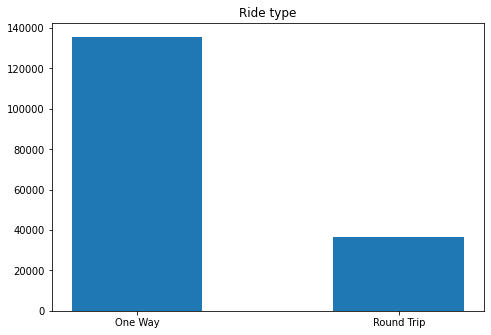

In [20]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title("Ride type")
langs = ['One Way', 'Round Trip']  
x = np.arange(len(langs))  # the label locations
width = 0.5  # the width of the bars
counts_mems = [len(df[(df["is_round"] == 0) & (df["member_casual"] == "member")]), len(df[(df["is_round"] > 0) & (df["member_casual"] == "member")])]
counts_cass = [len(df[(df["is_round"] == 0) & (df["member_casual"] != "member")]), len(df[(df["is_round"] > 0) & (df["member_casual"] != "member")])]
# rects1 = ax.bar(x - width/2, counts_mems, width, label='Member')
rects2 = ax.bar(x, counts_cass, width, label='Casual')
ax.set_xticks(x, langs)
plt.show()

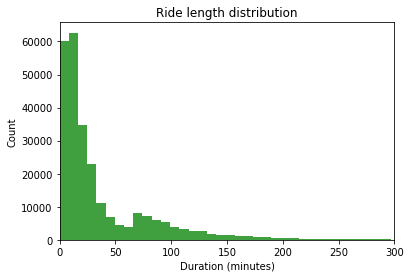

In [21]:
n, bins, patches = plt.hist(df["duration"], 5000, density=False, facecolor='g', alpha=0.75)



plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.title('Ride length distribution')
plt.xlim(0, 300)
plt.show()